# Difussion model EMNIST

## Libraries

In [ ]:
import os, math
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import EMNIST
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Hyperparams

In [ ]:

IMAGE_SIZE  = 32
CHANNELS    = 3
BATCH_SIZE  = 128
LR          = 1e-4
EPOCHS      = 15      
T_STEPS     = 1000
BETA_START  = 1e-4
BETA_END    = 2e-2
DEVICE      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_ROOT   = './data'
NUM_WORKERS = 0      # safe on Windows


In [ ]:
def linear_beta_schedule(timesteps):
    return torch.linspace(BETA_START, BETA_END, timesteps)

betas                = linear_beta_schedule(T_STEPS).to(DEVICE)
alphas               = 1.0 - betas
alpha_bar            = torch.cumprod(alphas, dim=0)
sqrt_alpha_bar       = torch.sqrt(alpha_bar)

def img_to_tensor(im: Image.Image) -> torch.Tensor:
    arr = np.array(im).astype(np.float32) / 255.0
    t   = torch.from_numpy(arr).permute(2,0,1)
    return t * 2 - 1

def tensor_to_image(t: torch.Tensor) -> Image.Image:
    arr = ((t.clamp(-1,1)+1)/2 * 255).byte().permute(1,2,0).cpu().numpy()
    return Image.fromarray(arr)


In [38]:
# Cell 3 — EMNIST Dataset & DataLoader

class EMNISTLettersDataset(Dataset):
    def __init__(self, split='train'):
        self.ds = EMNIST(
            root=DATA_ROOT,
            split='letters',
            train=(split=='train'),
            download=True
        )
        self.resize_rgb = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),
            transforms.Grayscale(num_output_channels=3),
        ])

    def __len__(self): 
        return len(self.ds)

    def __getitem__(self, idx):
        im, _ = self.ds[idx]             # L channel 28×28
        im     = self.resize_rgb(im)     # RGB 32×32
        x      = img_to_tensor(im)       # [3,32,32]
        return x

train_loader = DataLoader(
    EMNISTLettersDataset('train'),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


Test batch shape: torch.Size([128, 3, 32, 32])
Beta schedule range: 9.999999747378752e-05 to 0.019999999552965164
Alpha bar range: 0.9998999834060669 to 4.0358296246267855e-05
Device: cuda


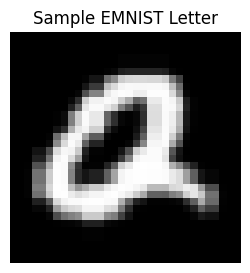

In [45]:
# Calculate sqrt_one_minus_alpha_bar for the diffusion process
sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - alpha_bar).to(DEVICE)

# Definitions to access time step values easily
def extract(a, t, shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu()).reshape(batch_size, *((1,) * (len(shape) - 1))).to(t.device)
    return out

# For visualizing the diffusion process
def show_tensor_image(image):
    image = (image.clamp(-1, 1) + 1) / 2
    image = image.detach().cpu().permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.axis('off')
    return image

# Create a test batch to verify the setup
test_batch = next(iter(train_loader))
print(f"Test batch shape: {test_batch.shape}")
print(f"Beta schedule range: {betas[0]} to {betas[-1]}")
print(f"Alpha bar range: {alpha_bar[0]} to {alpha_bar[-1]}")
print(f"Device: {DEVICE}")

# Show a sample image from the dataset
plt.figure(figsize=(3, 3))
show_tensor_image(test_batch[0])
plt.title("Sample EMNIST Letter")
plt.show()

## Unet implementation

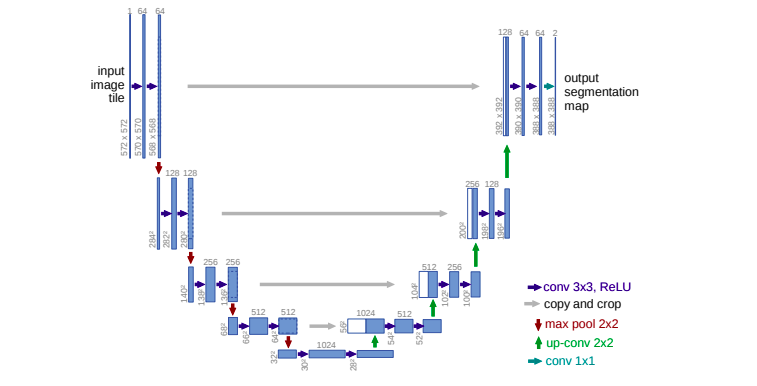

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_c, out_c))
    def forward(self, x): return self.net(x)

class Up(nn.Module):
    def __init__(self, in_c, out_c, skip_c):
        super().__init__()
        self.up   = nn.ConvTranspose2d(in_c, out_c, 2, stride=2)
        self.conv = DoubleConv(out_c + skip_c, out_c)
    def forward(self, x, skip):
        x = self.up(x)                    
        return self.conv(torch.cat([x, skip], dim=1))

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim*4), nn.ReLU(inplace=True),
            nn.Linear(dim*4, dim)
        )
    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) *
                          torch.arange(half, device=t.device) / half)
        args  = t.unsqueeze(1) * freqs.unsqueeze(0)
        emb   = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.mlp(emb)               

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_dim   = 128
        self.time_embed = TimeEmbedding(self.time_dim)
        self.tproj128   = nn.Linear(self.time_dim, 128)
        self.tproj64    = nn.Linear(self.time_dim,  64)

        self.inc   = DoubleConv(CHANNELS, 64)      # x1 64ch 32×32
        self.down1 = Down(64, 128)                 # x2 128ch 16×16
        self.down2 = Down(128,128)                 # x3 128ch  8×8
        self.bot   = DoubleConv(128,128)           # xb 128ch  8×8

        self.up2   = Up(128,128,128)               # 8->16, merge x2
        self.up1   = Up(128, 64,  64)              # 16->32, merge x1

        self.outc  = nn.Conv2d(64, CHANNELS, 1)

    def forward(self, x, t):
        t_embed = self.time_embed(t / T_STEPS)
        t128    = self.tproj128(t_embed).view(-1,128,1,1)
        t64     = self.tproj64(t_embed).view(-1, 64,1,1)

        x1 = self.inc(x)                   # 32×32 64ch
        x2 = self.down1(x1) + t128         # 16×16 128ch
        x3 = self.down2(x2) + t128         #  8×8 128ch
        xb = self.bot(x3)  + t128          #  8×8 128ch

        x  = self.up2(xb, x2) + t128       # 16×16 128ch
        x  = self.up1(x,  x1) + t64        # 32×32  64ch

        return self.outc(x)                # 32×32  3ch

model     = UNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
mse_loss  = nn.MSELoss()


## Training

In [40]:
from tqdm.notebook import tqdm

hist_loss = []            

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    num_seen     = 0

    # tqdm progress-bar over batches
    for x0 in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", unit="batch"):
        x0 = x0.to(DEVICE)
        B  = x0.size(0)
        t  = torch.randint(0, T_STEPS, (B,), device=DEVICE)
        a_bar = sqrt_alpha_bar[t].view(B,1,1,1)
        noise = torch.randn_like(x0)
        x_t   = a_bar * x0 + (1 - a_bar**2).sqrt() * noise

        noise_pred = model(x_t, t)
        loss       = mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * B
        num_seen     += B

    avg = running_loss / num_seen
    hist_loss.append(avg)               # store epoch loss
    print(f"✔️  Epoch {epoch:2d}/{EPOCHS} — mean loss: {avg:.6f}")


Epoch 1/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch  1/15 — mean loss: 0.156776


Epoch 2/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch  2/15 — mean loss: 0.048441


Epoch 3/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch  3/15 — mean loss: 0.037226


Epoch 4/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch  4/15 — mean loss: 0.032133


Epoch 5/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch  5/15 — mean loss: 0.028974


Epoch 6/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch  6/15 — mean loss: 0.026607


Epoch 7/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch  7/15 — mean loss: 0.025115


Epoch 8/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch  8/15 — mean loss: 0.024442


Epoch 9/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch  9/15 — mean loss: 0.022510


Epoch 10/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch 10/15 — mean loss: 0.021907


Epoch 11/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch 11/15 — mean loss: 0.021599


Epoch 12/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch 12/15 — mean loss: 0.020824


Epoch 13/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch 13/15 — mean loss: 0.020493


Epoch 14/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch 14/15 — mean loss: 0.019974


Epoch 15/15:   0%|          | 0/975 [00:00<?, ?batch/s]

✔️  Epoch 15/15 — mean loss: 0.019398


## Sampling

In [41]:
@torch.no_grad()
def sample(
    model,                     
    alphas, 
    alpha_bar, 
    betas,  
    n_samples=8
):
    model.eval()
    x = torch.randn(n_samples, CHANNELS, IMAGE_SIZE, IMAGE_SIZE, device=DEVICE)

    for t in reversed(range(T_STEPS)):
        t_batch  = torch.full((n_samples,), t, device=DEVICE, dtype=torch.long)
        eps_pred = model(x, t_batch)                        

        alpha_t         = alphas[t]
        alpha_bar_t     = alpha_bar[t]
        beta_t          = betas[t]

        mean  = (1 / torch.sqrt(alpha_t)) * (
                   x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * eps_pred
                )

        if t > 0:                                           
            x = mean + torch.sqrt(beta_t) * torch.randn_like(x)
        else:                                              
            x = mean

    return x.clamp(-1, 1)     

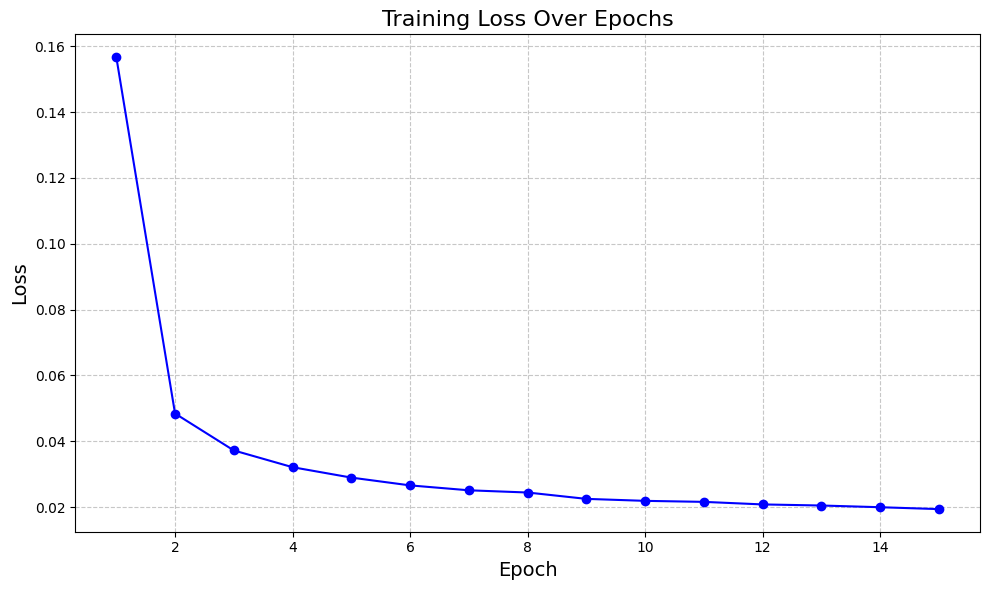

In [43]:
import matplotlib.pyplot as plt

# Plot the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(hist_loss) + 1), hist_loss, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Forward Diffusion Process (Adding Noise):


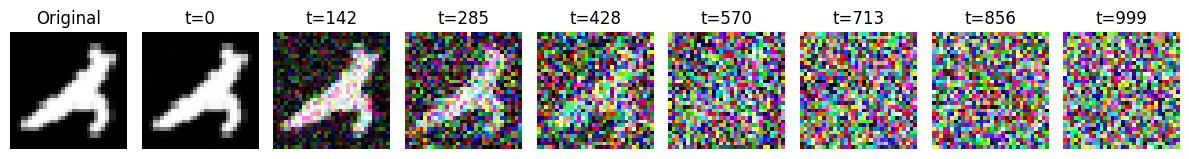

Reverse Diffusion Process (Removing Noise):


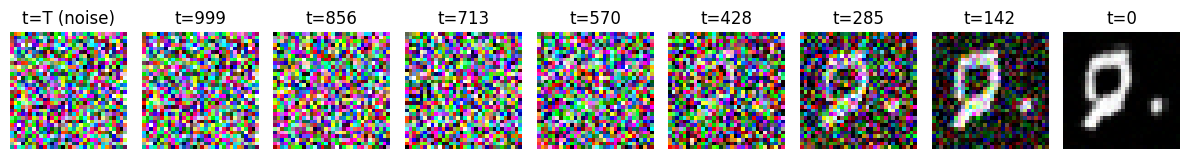

In [ ]:
@torch.no_grad()
def visualize_forward_diffusion(model, image_batch, timesteps=10):
    """Shows the forward diffusion process by gradually adding noise to an image"""
    model.eval()
    
    # Select a single image from the batch
    x0 = image_batch[0:1].to(DEVICE)
    
    # Generate equally spaced timesteps
    ts = torch.linspace(0, T_STEPS-1, timesteps).long().to(DEVICE)
    
    # Create the figure
    plt.figure(figsize=(12, 4))
    plt.subplot(1, timesteps+1, 1)
    plt.imshow(tensor_to_image(x0[0].cpu()))
    plt.axis('off')
    plt.title('Original')
    
    # Show the forward process
    for i, t in enumerate(ts):
        t_batch = torch.full((1,), t, device=DEVICE, dtype=torch.long)
        a_bar = sqrt_alpha_bar[t].view(1, 1, 1, 1)
        
        # Add noise based on timestep
        noise = torch.randn_like(x0)
        x_t = a_bar * x0 + (1 - a_bar**2).sqrt() * noise
        
        # Display
        plt.subplot(1, timesteps+1, i+2)
        plt.imshow(tensor_to_image(x_t[0].cpu()))
        plt.axis('off')
        plt.title(f't={t.item()}')
    
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def visualize_reverse_diffusion(model, timesteps=10):
    """Shows the reverse diffusion process by denoising from random noise"""
    model.eval()
    
    # Start with random noise
    x = torch.randn(1, CHANNELS, IMAGE_SIZE, IMAGE_SIZE, device=DEVICE)
    
    # Create steps to show in visualization
    steps = torch.linspace(T_STEPS-1, 0, timesteps).long().to(DEVICE)
    
    images = []
    images.append(x.clone())
    
    # Perform the reverse diffusion process and save intermediate steps
    for i, t in enumerate(reversed(range(T_STEPS))):
        t_batch = torch.full((1,), t, device=DEVICE, dtype=torch.long)
        eps_pred = model(x, t_batch)
        
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bar[t]
        beta_t = betas[t]
        
        # Compute the mean
        mean = (1 / torch.sqrt(alpha_t)) * (
            x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * eps_pred
        )
        
        # Add noise if t > 0
        if t > 0:
            x = mean + torch.sqrt(beta_t) * torch.randn_like(x)
        else:
            x = mean
        
        # Save images at specified steps
        if t in steps:
            images.append(x.clone())
    
    # Plot the reverse diffusion process
    plt.figure(figsize=(12, 4))
    for i, img in enumerate(images):
        if i < len(steps) + 1:  # Only show the first 10 steps
            plt.subplot(1, timesteps+1, i+1)
            plt.imshow(tensor_to_image(img[0].cpu()))
            plt.axis('off')
            if i == 0:
                plt.title('t=T (noise)')
            else:
                plt.title(f't={steps[i-1].item()}')
    
    plt.tight_layout()
    plt.show()

# Get a batch from the dataloader
sample_batch = next(iter(train_loader))

# Visualize both forward and reverse processes
print("Forward Diffusion Process (Adding Noise):")
visualize_forward_diffusion(model, sample_batch, timesteps=8)

print("Reverse Diffusion Process (Removing Noise):")
visualize_reverse_diffusion(model, timesteps=8)

## Output

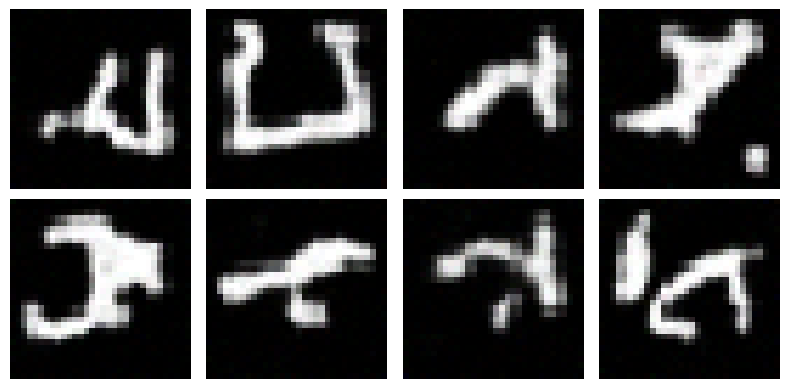

In [42]:
samples = sample(model, alphas, alpha_bar, betas, n_samples=8).cpu()

fig, axes = plt.subplots(2, 4, figsize=(8, 4))
for img, ax in zip(samples, axes.flatten()):
    ax.imshow(tensor_to_image(img))
    ax.axis("off")
plt.tight_layout()
plt.show()